Задание
1. Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект
DataFrame.
Вычислить распределение значений категориальных признаков по классам.
Визуализировать распределения. Разбить данные на обучающую и контрольную
выборки.
2. Построить решающую функцию по каждой переменной на основе частот. Сравнить
точность на обучающей и контрольной выборках. Найти наиболее информативную
переменную.
3. Построить «наивный» байесовский классификатор из sklearn. Оценить точность.
4. Самостоятельно реализовать метод, не используя готовый. Сравнить полученное
решение с библиотечным. Добавить регуляризатор в оценки частот.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import operator

from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [ ]:
features = ['bruises', 'odor','gill-attachment', 'gill-spacing', 'gill-size']
df = pd.read_csv('/content/mushrooms.csv')
mushrooms = df[['class','bruises', 'odor','gill-attachment', 'gill-spacing', 'gill-size']]
data_x = mushrooms[features]
data_y = mushrooms['class']

object_count = data_x.shape[0]
features_count = data_x.shape[1]

In [ ]:
mushrooms 

,class,bruises,odor,gill-attachment,gill-spacing,gill-size
0,p,t,p,f,c,n
1,e,t,a,f,c,b
2,e,t,l,f,c,b
3,p,t,p,f,c,n
4,e,f,n,f,w,b
...,...,...,...,...,...,...
8119,e,f,n,a,c,b
8120,e,f,n,a,c,b
8121,e,f,n,a,c,b
8122,p,f,y,f,c,n


In [ ]:
mushrooms.shape

(8124, 6)

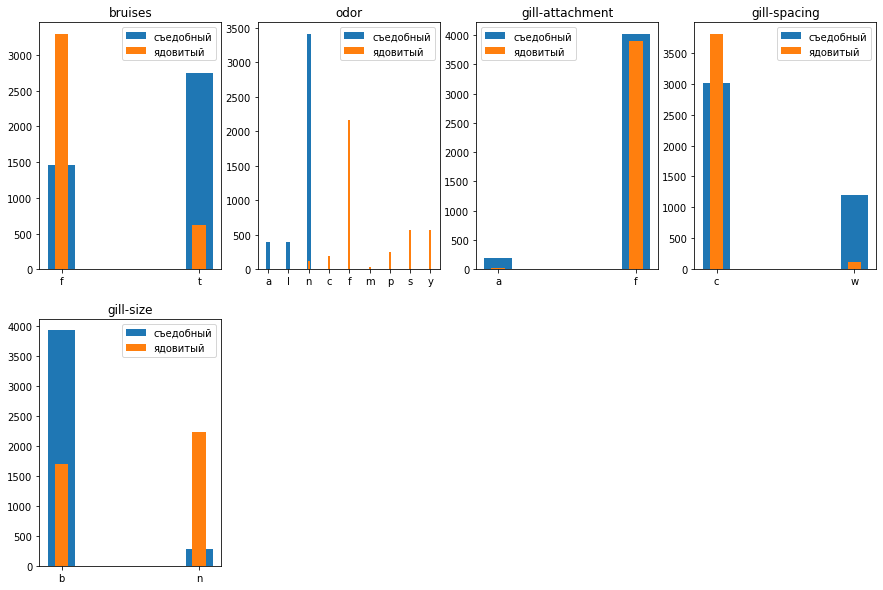

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
for i in range(2):
    for j in range(4):
        if i*4 + j >= features_count:
            axs[i, j].axis('off')
            continue
        feature = features[i*4+j]         
        edible_feature_values, edible_feature_values_counts = \
            np.unique(data_x[data_y == 'e'][feature], return_counts=True)
        poisonous_feature_values, poisonous_feature_values_counts = \
            np.unique(data_x[data_y == 'p'][feature], return_counts=True)
        
        axs[i, j].bar(edible_feature_values, edible_feature_values_counts, width=0.2, label='съедобный')
        axs[i, j].bar(poisonous_feature_values, poisonous_feature_values_counts, width=0.1, label='ядовитый')
        axs[i, j].set_title(feature)
        axs[i, j].legend()
        
        edible_distributions = dict(zip(edible_feature_values, edible_feature_values_counts/object_count))
        poisonous_distributions = dict(zip(edible_feature_values, poisonous_feature_values_counts/object_count))

In [ ]:
encoder = OneHotEncoder().fit(data_x)
data_x_onehot = encoder.transform(data_x).toarray()
data_x_train, data_x_test, data_y_train, data_y_test = \
    train_test_split(data_x_onehot, data_y, test_size=0.3)

**2. решающая функция по каждой переменной на частот**

In [ ]:
class FreqDiscriminator:
    def fit(self, x, y):
        y_classes, y_probs = list(np.unique(y, return_counts=True))
        y_probs = y_probs / y.shape[0]        
        self.y_probs = dict(zip(y_classes, y_probs))
        
        self.x_probs_by_y = {}
        for y_class in y_classes:
            x_by_y = x[y == y_class]
            self.x_probs_by_y[y_class] = sum(x_by_y)/x_by_y.shape[0]

    def pred(self, val):
        probs = {}
        for y in self.x_probs_by_y.keys():
            probs[y] = self.y_probs[y] * sum(self.x_probs_by_y[y]*val)
        return max(probs.items(), key=operator.itemgetter(1))[0]
        
    def predict(self, x):
        return np.asarray([self.pred(val) for val in x])

feature_start_index = 0
for i in range(len(features)):
    fd = FreqDiscriminator()
    category = encoder.categories_[i]
    feature_range = range(feature_start_index, feature_start_index+len(category))
    fd.fit(data_x_train[:, feature_range], data_y_train)
    y_pred_train = fd.predict(data_x_train[:, feature_range])
    y_pred_test = fd.predict(data_x_test[:, feature_range])
    print(f'точность [обучающая, {features[i]}]:', 
          len(y_pred_train[y_pred_train == data_y_train])/len(data_y_train))
    print(f'точность [контрольная, {features[i]}]:', 
          len(y_pred_test[y_pred_test == data_y_test])/len(data_y_test))
    feature_start_index += len(category)

точность [обучающая, bruises]: 0.742525501231094
точность [контрольная, bruises]: 0.7473338802296965
точность [обучающая, odor]: 0.9859303552585297
точность [контрольная, odor]: 0.9835931091058244
точность [обучающая, gill-attachment]: 0.51952163207879
точность [контрольная, gill-attachment]: 0.5143560295324036
точность [обучающая, gill-spacing]: 0.6158986985578614
точность [контрольная, gill-spacing]: 0.616078753076292
точность [обучающая, gill-size]: 0.7604642982764686
точность [контрольная, gill-size]: 0.7465135356849877


**самая информативная переменная - odor**

In [ ]:
model = BernoulliNB()
model.fit(data_x_train, data_y_train)

sk_nb_y_pred_train = model.predict(data_x_train)
sk_nb_y_pred_test = model.predict(data_x_test)

print('Точность[обучающая]:', 
      len(sk_nb_y_pred_train[sk_nb_y_pred_train == data_y_train])/len(data_y_train))
print('Точность[контрольная]:', 
      len(sk_nb_y_pred_test[sk_nb_y_pred_test == data_y_test])/len(data_y_test))

Точность[обучающая]: 0.9715089693985227
Точность[контрольная]: 0.9639048400328137


In [ ]:
class NaiveBayes:
    def fit(self, x, y, regularize = False):
        probs = {}
        y_classes = list(np.unique(y))
        for y_class in y_classes:
            x_by_y = x[y == y_class]
            x_probs_by_y = []
            for pos in range(x.shape[1]):
                x_by_y_pos = x_by_y[:,pos]
                one_prob = (x_by_y_pos.sum()+int(regularize)) / (x_by_y_pos.shape[0]+1+int(regularize))
                zero_prob = 1 - one_prob
                x_probs_by_y.append((zero_prob, one_prob))
            probs[y_class] = x_probs_by_y
        self.probs = probs
    
    def pred(self, row):
        probs = {}
        for y in self.probs.keys():
            prob = 1
            for pos in range(len(row)):
                prob *= self.probs[y][pos][int(row[pos])]
            probs[y] = prob
        return max(probs.items(), key=operator.itemgetter(1))[0]
    
    def predict(self, x):
        return np.apply_along_axis(self.pred, 1, x)

In [ ]:
nb = NaiveBayes()
nb.fit(data_x_train, data_y_train)

nb_y_pred_train = nb.predict(data_x_train)
nb_y_pred_test = nb.predict(data_x_test)

print('Без регуляризации\nТочность [обучающая]:', 
      len(nb_y_pred_train[nb_y_pred_train == data_y_train])/len(data_y_train))
print('Точность [контрольная]:', 
      len(nb_y_pred_test[nb_y_pred_test == data_y_test])/len(data_y_test))



nb.fit(data_x_train, data_y_train, regularize = True)

nb_y_pred_train = nb.predict(data_x_train)
nb_y_pred_test = nb.predict(data_x_test)

print('С регуляризацией\nТочность [обучающая]:', 
      len(nb_y_pred_train[nb_y_pred_train == data_y_train])/len(data_y_train))
print('Точность [контрольная]:', 
      len(nb_y_pred_test[nb_y_pred_test == data_y_test])/len(data_y_test))

Без регуляризации
Точность [обучающая]: 0.9736194161097432
Точность [контрольная]: 0.9663658736669402
С регуляризацией
Точность [обучающая]: 0.9736194161097432
Точность [контрольная]: 0.9663658736669402


In [ ]:
logit_train = logit(model.predict_proba(data_x_train))
logit_test = logit(model.predict_proba(data_x_test))

In [ ]:
big_num = pow(10, 10)
for i in range(len(logit_train)):
    for j in range(2):
        if logit_train[i,j] == np.inf:
            logit_train[i,j] = big_num
        if logit_train[i,j] == -np.inf:
            logit_train[i,j] = -big_num
for i in range(len(logit_test)):
    for j in range(2):
        if logit_test[i,j] == np.inf:
            logit_test[i,j] = big_num
        if logit_test[i,j] == -np.inf:
            logit_test[i,j] = -big_num

In [ ]:
logreg = LogisticRegression().fit(logit_train, data_y_train)
predict = logreg.predict(logit_test)
print('Точность [обучающая]:', 
      sum(logreg.predict(logit_train) == data_y_train)/len(data_y_train))
print('Точность [контрольная]:', 
      sum(logreg.predict(logit_test) == data_y_test)/len(data_y_test))

Точность [обучающая]: 0.9715089693985227
Точность [контрольная]: 0.9639048400328137


In [ ]:
model.predict_proba(data_x_train)

array([[1.44570363e-06, 9.99998554e-01],
       [9.99704131e-01, 2.95868908e-04],
       [9.99704131e-01, 2.95868908e-04],
       ...,
       [9.99858583e-01, 1.41417099e-04],
       [9.99704131e-01, 2.95868908e-04],
       [9.99704131e-01, 2.95868908e-04]])

In [ ]:
class NaiveBayes:
    def fit(self, x, y, regularize = False):
        probs = {}
        y_classes = list(np.unique(y))
        for y_class in y_classes:
            x_by_y = x[y == y_class]
            x_probs_by_y = []
            for pos in range(x.shape[1]):
                x_by_y_pos = x_by_y[:,pos]
                if regularize:
                    one_prob = (x_by_y_pos.sum()+1) / (x_by_y_pos.shape[0]+2) 
                else:
                    one_prob = (x_by_y_pos.sum()) / (x_by_y_pos.shape[0]+1) 
                zero_prob = 1 - one_prob
                x_probs_by_y.append((zero_prob, one_prob))
            probs[y_class] = x_probs_by_y
        self.probs = probs
    
    def pred(self, row):
        probs = {}
        for y in self.probs.keys():
            prob = 1
            for pos in range(len(row)):
                prob *= self.probs[y][pos][int(row[pos])]
            probs[y] = prob
        return max(probs.items(), key=operator.itemgetter(1))[0]
    
    def probobos(self, row):
        probs = {}
        for y in self.probs.keys():
            prob = 1
            for pos in range(len(row)):
                prob *= self.probs[y][pos][int(row[pos])]
            probs[y] = prob
        return probs
    
    def predict_proba(self, x):
        return np.apply_along_axis(self.probobos, 1, x)
    
    def predict(self, x):
        return np.apply_along_axis(self.pred, 1, x)

In [ ]:
nb = NaiveBayes()
nb.fit(data_x_train, data_y_train, regularize=True)

nb_y_pred_train = nb.predict(data_x_train)
nb_y_pred_test = nb.predict(data_x_test)

nb.predict_proba(data_x_train)

array([{'e': 1.3842349503699563e-08, 'p': 0.010352844904851475},
       {'e': 0.11212297425096815, 'p': 3.587998454147921e-05},
       {'e': 0.11212297425096815, 'p': 3.587998454147921e-05}, ...,
       {'e': 0.002811717645684177, 'p': 4.2999642679344056e-07},
       {'e': 0.11212297425096815, 'p': 3.587998454147921e-05},
       {'e': 0.11212297425096815, 'p': 3.587998454147921e-05}],
      dtype=object)

In [ ]:
len(data_x_train)

5686

In [ ]:
nb.probs['p']

[(0.15874177029992687, 0.8412582297000731),
 (0.8412582297000731, 0.15874177029992684),
 (0.9996342355523044, 0.000365764447695684),
 (0.9495245062179956, 0.05047549378200439),
 (0.4476956839795172, 0.5523043160204828),
 (0.9996342355523044, 0.000365764447695684),
 (0.9915874177029993, 0.008412582297000731),
 (0.9703730797366495, 0.0296269202633504),
 (0.9323335771762985, 0.06766642282370154),
 (0.8525969275786394, 0.14740307242136064),
 (0.8540599853694221, 0.1459400146305779),
 (0.9952450621799561, 0.004754937820043892),
 (0.004754937820043881, 0.9952450621799561),
 (0.029992684711046103, 0.9700073152889539),
 (0.9700073152889539, 0.029992684711046085),
 (0.5753474762253109, 0.4246525237746891),
 (0.4246525237746891, 0.5753474762253109)]